시도해 본 방법론들은 아래와 같습니다.

(1) EMNIST data(12만 장)를 데이콘 데이터와 유사하게 구축 후 classfication task에 pre-training -> 본 대회 학습<br>
  위 방법을 사용하는 경우와 그렇지 않은 경우 초기 convergence 속도가 크게 차이가 납니다만, 막상 결과에는 유의미한 차이가 없었습니다.

(2) Custom loss 사용<br>
  기본적으로 MultiLabelSoftMarginLoss(BCEwithLogitLoss)을 사용하였는데, CE와 달리 독립적으로 확률을 계산하다보니 약간 애매하게 생긴 M과 같은 글자에 대해 W, M 모두의 확률값이 높게 예측되어 무조건 하나는 틀리게 되더군요.. 이 현상을 잡으면 정확도가 크게 올라갈 것 같아 예측 개수를 제한하는 loss term을 추가 실험해봤는데 큰 개선효과는 얻지 못했습니다. DACON.JIN님께서 공유해주신 CAM을 활용해서 NMS 형식으로 중복 예측을 제거해보면 어떨까 싶었는데 시간상 시도는 못해봤습니다.

(3) 노이즈 제거<br>
  인풋 이미지의 노이즈를 open-cv를 활용해 제거해서 사용해봤습니다.
  gaussian blur와 cv2.fastNlMeansDenoising를 적절히 사용하면 깔끔한 흑-백 이미지가 만들어집니다만, 오히려 성능은 좋지 않았습니다.
  결국에는 original dataset만을 이용해 학습하였습니다. Clahe같은 다른 기법도 썼다면 성능 향상이 조금이라도 됐을까 궁금하긴 합니다.
  
(4) Label Smoothing<br>
  앞서 (2)번에서의 이슈와 관련해, label smoothing을 적용해보면 어떨까 싶어서 적용해봤습니다.
  multi-label classification에서 label smoothing을 사용해봤다는 소스는 찾지 못해 단순히 1 -> 0.9, 0 -> 0.1로 바꿔서 학습을 해봤는데 성능은 비슷했습니다.
  
(5) Augmix<br>
  Augmix 같은 augmentation 기법을 사용해 augmentation을 수행해봤지만, 성능 악화로 이어졌습니다.
  generalization을 위한 정도로만 사용하는 것이 경험 상 가장 좋았던 것 같습니다.

# Library Import

In [22]:
import os
import csv
import cv2
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold
import random
from time import time
import IPython
import copy

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from warmup_scheduler import GradualWarmupScheduler

from src.train import train_model
#from utils.imageprocess import image_transformer, image_processor
from utils.imageprocess import image_transformer
from utils.earlystopping import EarlyStopping
from utils.data_loader import CustomDataLoader
from utils.call_model import CallModel

#안 됌
# from utils.radams import RAdam

from tqdm import tqdm
import logging

#RAdam(Rectified Adam):Adam의 개선방안<br>
Adam이 사용하던 adaptive learning rate는 학습초기에 표본이 적기 때문에 분산이 발산하고, 이로 인해 learning rate에 곱해지는 값이 제한없이 커져서 학습이 local optima에 빠진다

해결:Adaptive learning rate 계산에 사용되는 지수이동평균의 분산이 자유도가 증가함에 따라 단조로 감소하고 자유도를 기준으로 adaptive learning rate를 동적으로 적용해 분산이 발산하는 문제를 해결

ref:https://choice-life.tistory.com/34

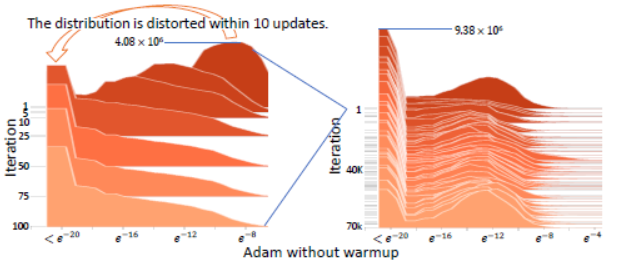

In [23]:
#Import RAdam 대신 직접 넣기
#따로 github에서 찾음
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)   

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

## Model 정의
우선 실험에 사용할 resnet50부터 efficientnet 계열 모델을 정의해놓고, 학습 시 호출하여 사용합니다.<br>
Pretrained 모델을 사용하였고, 마지막 classifier인 fc layer만 xavier initialization을 하여 학습에 이용하였습니다.<br>

Resnet50/EfficientnetB4/B5/B7 을 import

In [24]:
# model.py
"""
Here every model to be used for pretraining/training is defined.
"""
class PlainResnet50(nn.Module):
    def __init__(self):
        super(PlainResnet50, self).__init__()
        
        base_model = resnet50()
        self.block = nn.Sequential(
            base_model,
            nn.Linear(1000, 26),
        )
        
        nn.init.xavier_normal_(self.block[1].weight)
        
    def forward(self, x):
        out = self.block(x)
        return out

    
class PlainEfficientnetB4(nn.Module):
    def __init__(self):
        super(PlainEfficientnetB4, self).__init__()
        
        base_model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=26)
        self.block = nn.Sequential(
            base_model
        )
        
        nn.init.xavier_normal_(self.block[0]._fc.weight)
        
    def forward(self, x):
        out = self.block(x)
        return out


class PlainEfficientnetB5(nn.Module):
    def __init__(self):
        super(PlainEfficientnetB5, self).__init__()
        
        base_model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=26)
        self.block = nn.Sequential(
            base_model
        )
        
        nn.init.xavier_normal_(self.block[0]._fc.weight)
        
    def forward(self, x):
        out = self.block(x)
        return out


class PlainEfficientnetB7(nn.Module):
    def __init__(self):
        super(PlainEfficientnetB7, self).__init__()
        
        base_model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=26)
        self.block = nn.Sequential(
            base_model
        )
        
        nn.init.xavier_normal_(self.block[0]._fc.weight)
        
    def forward(self, x):
        out = self.block(x)
        return out

In [1]:
# call_model.py

class CallModel():
    def __init__(self, model_type=None, pretrained=True, logger=None, path='./pretrained_model'):
        
        # MODEL TYPE
        if model_type == 'plain_resnet50':
            base_model = PlainResnet50()
            weight_path = os.path.join(path, 'plain_resnet50_ckpt.pth')

        elif model_type == 'plain_efficientnetb4':
            base_model = PlainEfficientnetB4()
            weight_path = os.path.join(path, 'plain_efficientnetb4_ckpt.pth')
            
        elif model_type == 'plain_efficientnetb5':
            base_model = PlainEfficientnetB5()
            weight_path = os.path.join(path, 'plain_efficientnetb5_ckpt.pth')
            
        elif model_type == 'plain_efficientnetb7':
            base_model = PlainEfficientnetB7()
            weight_path = os.path.join(path, 'plain_efficientnetb7_ckpt.pth')
            
        else:
            raise Exception(f"No such model type: {model_type}")
        
        
        # LOAD PRETRAINED WEIGHTS
        if pretrained:
            logger.info(f"Using pretrained model. Loading weights from {weight_path}")
            base_model = CallModel._load_weights(base_model, weight_path)
            
            # b5 model
            nn.init.xavier_normal_(base_model.block[0]._fc.weight)
           
        else:
            logger.info(f"Not using pretrained model.")
        
        self.model = base_model
            
    def model_return(self):
        return self.model
        
    @staticmethod
    def _load_weights(model, path):
        model.load_state_dict(torch.load(path))
        return model

# Dataloader 정의
학습에 사용하기 위한 dataloader를 정의합니다.<br>
저희 팀의 경우 inference 시 TTA(test time augmentation)를 각도 변화(0, 90, -90, 180)에 따른 augmentation 만으로 수행했고, 아래 tta와 angle이 해당하는 argument들입니다.<br>

ref:https://shinminyong.tistory.com/43

### TTA(Test Time Augmentation)

1장으로 test할 것을 augmentation하여 여러장에 대해서 예측하게 한 후 그 평균을 구해서 원래 1장에 대한 예측값으로결정

->여러장으로 test 해서 예측오차율을 줄일 수 있다.

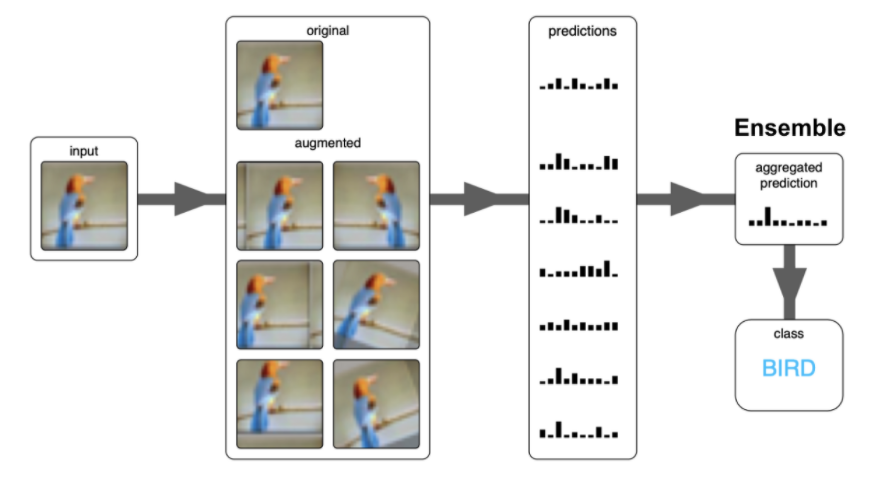

In [25]:
# dataloader.py

class CustomDataLoader():
    
    def __init__(self, img_dir=None, label_dir=None, train=True, row_index=None, device=None, tta=False, angle=None):
        """
        Arguments:
        img_dir  : Where train dataset is located, e.g. /loc/of/your/path/trainset
        label_dir: Where label csv file is located, e.g. /loc/of/your/path/LABEL.csv
        train    : Used to specify trainset. For validation and testset, set this value as False.
        row_idx  : Mainly used for train/val split. Among all images it specifies which row should be processed.
            Usage INPUT:np.array()
                  e.g. np.array([1, 5, 10, 102, ...])
        use_cuda : Decide whether to use cuda. If cuda is not available, it will be set False.
        """
        assert os.path.exists(img_dir) and os.path.exists(label_dir), "Path not exists."
        
        self.img_dir = img_dir
        self.label_dir = label_dir
        
        label_df = pd.read_csv(label_dir)
        
        self.label_index = label_df.iloc[row_index, 0].values
        self.label_values = label_df.iloc[row_index, 1:].values
        
        # Transformation
        self.train = train

        # Set device
        self.device = device
        
        # TTA(at inference)
        self.tta = tta
        self.angle = angle
        

    def __len__(self):
        return self.label_index.__len__()
    
    
    def __getitem__(self, item_index):
        """
        This method returns [label, image] given an index.
        Returned values are of torch.tensor type.
        """
        idx = item_index
        label = self.label_values[idx]
        
        image_idx = str(self.label_index[idx]).zfill(5) + '.png'
        image_path = os.path.join(self.img_dir, image_idx)
        assert os.path.exists(image_path), f"Given image path not exists: {image_path}"
        
        pil_image = Image.open(image_path).convert('RGB')
        
        if not self.tta:
            fin_image = image_transformer(pil_image, self.train)
        else:
            fin_image = tta_transformer(pil_image, self.angle)

        # To torch.tensor type
        image_item = fin_image.float().to(self.device)
        label_item = torch.tensor(label).float().to(self.device)
        
        return image_item, label_item

# Image Processor 정의
Image를 불러올 때 normalization, rotation 등을 수행하기 위한 함수를 정의합니다.<br>

RandomRotation의 경우 회전 시 글자가 잘리는 경우를 위해 expand=True로 설정해야 하나, 이게 학습에 그다지 좋지 않은 영향을 끼치는 것 같아<br>
아래와 같이 RotateTransform 함수를 따로 정의해서 정해진 각도(90, -90, 180)으로만 rotation을 수행했습니다.<br>
그 외에는 약한 RandomPerspective을 줘서 robustness를 올려봤습니다.<br>
Flip은 알파벳 b와 d 같은 경우 때문에 굳이 안쓰는게 낫다고 판단해서 안썼는데, 경험상 쓰나 안쓰나 큰 차이는 없었던 것 같습니다.<br>

저희가 다양하게 augmentation을 해본 결과로는, augmentation을 강하게 준 경우 오히려 학습에 악영향이 큰 것 같았습니다.<br>
단순 classfication이 아니라 알파벳을 인식해야 하는 task라서 그렇지 않나 싶습니다.<br>

## 결론:augmentation이 효과 없었음

## Normalization
Normalization의 경우 ImageNet과 특성이 매우 다른 데이터이다보니,
* [0.5,], [0.5,]로 normalization 한 EMNIST 데이터에 pretraining -> 데이콘 데이터 학습<br>
※EMNIST: Extended MNIST
* Pretraining 없이 [0.5,], [0.5,]로 normalization 후 학습<br>
* ImageNet dataset 분포로 normalization 후 학습<br>

세가지를 실험해봤는데, [0.5,], [0.5,]로 해도 충분히 좋은 결과가 있었던 것 같습니다. (-1 ~ 1로 정규화)

In [26]:
# imageprocess.py

class RotateTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        if isinstance(self.angles, list):
            angle = random.choice(self.angles)
        else:
            angle = self.angles
        return TF.rotate(x, angle)


def image_transformer(input_image=None, train=True):
    """
    Using torchvision.transforms, make PIL image to tensor image
    with normalizing and flipping augmentations
    """
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    if train:
        transformer = transforms.Compose([        
            RotateTransform([0, 0, 0, -90, 90, 180]),
            transforms.RandomPerspective(distortion_scale=0.15, p=0.2),
            #transforms.RandomHorizontalFlip(p=0.2),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        transformer = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    transformed_image = transformer(input_image)
    
    return transformed_image



def tta_transformer(input_image, angle):
    """
    Test Time Augmentation for creating final test labels.
    """
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    transformer = transforms.Compose([        
        RotateTransform(angle),
        transforms.ToTensor(),
        normalize,
    ])

    transformed_image = transformer(input_image)
    
    return transformed_image

# Early Stopper
저희는 early stopper를 애용합니다. 특히 이미지 task의 경우 early stopper가 좋은 효과가 있다고 생각합니다.<br>
코드는 인터넷에 올라와있는 코드(<https://github.com/Bjarten/early-stopping-pytorch>)를 참고하시면 됩니다.<br>

patience를 크게 가져가는 경우 validation acc는 많이 올라도 test 결과는 크게 악화되어서, 최종 결과에는 4를 설정했습니다.<br>

※patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의

In [27]:
# ealrystopping.py

class EarlyStopping:
    
    def __init__(self, patience=7, verbose=False, delta=0, fold_k=1, path='./early_stopped.pth'):
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        
        if os.path.splitext(path)[-1] == '.pth':
            self.path = path
        else:
            self.path = os.path.join(path, f'early_stopped_fold{fold_k}.pth')

        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Train
본격적인 학습 코드입니다.<br>

warmup은 무조건 사용하는게 좋은 것 같고, LR scheduler의 경우 cosine annealing이나 ReduceLROnPlateau는 overfitting이 많이 발생하는 것 같습니다. 몇 번의 실험 후로는 multi-step scheduler만 사용해서 overfitting 방지에 좀 더 치중했습니다. 느낀 바로는 이미지 task의 경우 multistep scheduler을 사용함으로써 훨씬 안정적인 학습이 이루어진다고 생각합니다.<br>

추가적으로는 APEX Amp를 사용해서 batch size를 늘려 학습하였습니다. 코드 공유에도 올라와있는데, 사용을 하는 것과 아닌 것 간에 차이가 굉장히 크다고 느꼈습니다.
다만 resnet의 경우 batch size가 32~64 정도일 때가 16일 때에 비해 좀 더 나은 성능을 보였었기 때문에 efficientnet-b7의 경우도 32정도까지 batch를 늘리면 성능이 조금 높아지지 않을까 생각합니다. 여건이 되면 ddp 등을 사용해보면 어떨까 싶습니다.<br>

옵티마이저는 RAdam을 사용했는데, Adam에 학습 속도가 크게 개선되는 것 같습니다. 최종 성능 비교는 해보지 않았습니다.<br>

In [28]:
# train.py

def train_model(input_model, fold_k, model_save_path, args, logger, *loaders):
    
    fold_k = fold_k+1
    
    model = input_model
    epochs = args.epochs
    learning_rate = args.learning_rate
    
    logger = logger
    train_loader = loaders[0]
    val_loader = loaders[1]
    
    early_stopping = EarlyStopping(patience=args.patience, verbose=False, fold_k=fold_k, path=model_save_path)

    # ----------------------
    #  Loss function / Opt
    # ----------------------
    loss_function = MultiLabelSoftMarginLoss()
    
    ############## RAdam
    optimizer = RAdam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4)
    
    
    # -----------------
    #   amp wrapping
    # -----------------
    scaler = amp.GradScaler()

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                                        milestones=[
                                                            int(args.epochs*0.3),
                                                            int(args.epochs*0.4),
                                                            int(args.epochs*0.6)
                                                        ],
                                                        gamma=0.7)

    logger.info(f"""
---------------------------------------------------------------------------
    TRAINING INFO
        Loss function : {loss_function}
        Optimizer     : {optimizer}
        LR_Scheduler  : {lr_scheduler}
---------------------------------------------------------------------------""")
    
    # ----------------
    #     WARM-UP
    # ----------------
    warmup_epochs = int(args.epochs * 0.15)
    lr_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=lr_scheduler)
    
    train_tot_num = train_loader.dataset.__len__()
    val_tot_num = val_loader.dataset.__len__()
    
    train_corrects_sum = 0
    train_loss_sum = 0.0
    
    val_corrects_sum = 0
    val_loss_sum = 0.0
    
    logger.info(f'Training begins... Epochs = {epochs}')
    
    for epoch in range(epochs):
        
        time_start = time()

        if epoch <= warmup_epochs:
            lr_warmup.step()
        
        logger.info(f"""
===========================================================================
    PHASE INFO
        Current fold  : Fold ({fold_k})
        Current phase : {epoch+1}th epoch
        Learning Rate : {optimizer.param_groups[0]['lr']:.6f}
---------------------------------------------------------------------------""")
        
        torch.cuda.empty_cache()
        model.train()
        
        train_tmp_num = 0
        train_tmp_corrects_sum = 0
        train_tmp_loss_sum = 0.0
        for idx, (train_X, train_Y) in enumerate(train_loader):
            
            #IPython.embed(); exit(1)
            train_tmp_num += len(train_Y)
            
            optimizer.zero_grad()
            
            with amp.autocast():
                train_pred = model(train_X)
                train_loss = loss_function(train_pred, train_Y)
            
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_pred_label = train_pred > args.threshold
            train_corrects = (train_pred_label == train_Y).sum()
            train_corrects_sum += train_corrects.item()
            
            train_loss_sum += train_loss.item()
            
            train_tmp_corrects_sum += train_corrects.item()
            train_tmp_loss_sum += train_loss.item()
            
            # Check between batches
            verbose = args.verbose
            
            if (idx+1) % verbose == 0:
                print(f"-- ({str((idx+1)).zfill(4)} / {str(len(train_loader)).zfill(4)}) Train Loss: {train_tmp_loss_sum/train_tmp_num:.6f} | Train Acc: {train_tmp_corrects_sum/(train_tmp_num*26)*100:.4f}%")
                
                # initialization
                train_tmp_num = 0
                train_tmp_corrects_sum = 0
                train_tmp_loss_sum = 0.0
            
        
        with torch.no_grad():
            
            for idx, (val_X, val_Y) in enumerate(val_loader):
                
                with amp.autocast():
                    val_pred = model(val_X)
                    val_loss = loss_function(val_pred, val_Y)
                
                val_pred_label = val_pred > args.threshold
                val_corrects = (val_pred_label == val_Y).sum()
                val_corrects_sum += val_corrects.item()
                
                val_loss_sum += val_loss.item()
                
        train_acc = train_corrects_sum/(train_tot_num*26)*100
        train_loss = train_loss_sum/train_tot_num
        
        val_acc = val_corrects_sum/(val_tot_num*26)*100
        val_loss = val_loss_sum/val_tot_num
        
        time_end = time()
        time_len_m, time_len_s = divmod(time_end - time_start, 60)
        
        logger.info(f"""
---------------------------------------------------------------------------
    SUMMARY
        Finished phase  : {epoch+1}th epoch
        Time taken      : {time_len_m:.0f}m {time_len_s:.2f}s
        Training Loss   : {train_loss:.6f}  |  Training Acc   : {train_acc:.4f}%
        Validation Loss : {val_loss:.6f}  |  Validation Acc : {val_acc:.4f}%
===========================================================================\n""")
        
        # -------------------
        #    EARLY STOPPER
        # -------------------
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            logger.info("Early stopping condition met --- TRAINING STOPPED")
            logger.info(f"Best score: {early_stopping.best_score}")
            break
        
        # INITIALIZATION
        train_corrects_sum = 0
        val_corrects_sum = 0
        
        train_loss_sum = 0.0
        val_loss_sum = 0.0
  
        lr_scheduler.step()

    return model

# 메인 함수
학습/추론을 위한 main.py 코드입니다.<br>

In [29]:
# main.py

# -----------------------------
#  train/val splitting method
# -----------------------------
def split_index(total_index, val_ratio):
    tot_len = len(total_index)
    train_len = int(tot_len*(1-val_ratio))

    train_sampled = random.sample(total_index, train_len)
    val_sampled = [i for i in total_index if i not in train_sampled]
    logger.info(f"Trainset length: {len(train_sampled)}, Valset length: {len(val_sampled)}")
    
    return train_sampled, val_sampled


def split_kfold(k, train_len=50000):    
    kfold = KFold(n_splits=k, shuffle=True)
    splitted = kfold.split(range(train_len))
    return splitted



def split_dataset(args):
    if args.fold_k == 1:
        train_index_set, val_index_set = split_index(range(50000), args.val_ratio)
        train_index_set, val_index_set = [train_index_set], [val_index_set]
        
    elif args.fold_k > 1:
        splitted = split_kfold(args.fold_k, train_len=50000)
        train_index_set, val_index_set = [], []
        
        for train_fold, val_fold in splitted:
            train_index_set.append(train_fold)
            val_index_set.append(val_fold)
        
        logger.info(f"Trainset length: {len(train_index_set[0])}, Valset length: {len(val_index_set[0])}")
    
    test_index = range(5000)
    
    return train_index_set, val_index_set, test_index
    





# -----------------------------------
#   Setting seeds for reproduction
# -----------------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.device_count() > 0:
        torch.cuda.manual_seed_all(seed)


# ----------------------
#    Loading Dataset
# ----------------------
def load_dataset(mode='train', **kwargs):
    '''
    If tta is used at inference(mode=test),
    you must specify angles used for the augmentation.
    '''
    img_dir = kwargs['img_dir']
    label_dir = kwargs['label_dir']
    device = kwargs['device']

    if mode=='train':
        
        train_index = kwargs['train_index']
        val_index = kwargs['val_index']
        batch_size = kwargs['batch_size']
        
        train_set = CustomDataLoader(
            img_dir=img_dir,
            label_dir=label_dir,
            train=True,
            row_index=train_index,
            device=device)

        val_set = CustomDataLoader(
            img_dir=img_dir,
            label_dir=label_dir,
            train=False,
            row_index=val_index,
            device=device)

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

        return train_loader, val_loader

    else:
        test_index = kwargs['test_index']
        tta = kwargs['tta']
        
        if not tta:
            tmp_test_set = CustomDataLoader(
                img_dir=img_dir,
                label_dir=label_dir,
                train=False,
                row_index=test_index,
                device=device)
            tmp_test_loader = torch.utils.data.DataLoader(tmp_test_set, batch_size=128, shuffle=False)
            test_loader = [tmp_test_loader]
        
        else:
            angles = kwargs['angles']
            
            test_loader = []
            for angle in angles:
                tmp_test_set = CustomDataLoader(
                    img_dir=img_dir,
                    label_dir=label_dir,
                    row_index=test_index,
                    device=device,
                    tta=True,
                    angle=angle)
                
                tmp_test_loader = torch.utils.data.DataLoader(tmp_test_set, batch_size=128, shuffle=False)
                test_loader.append(tmp_test_loader)

        return test_loader


def load_trained_weight(model_input=None, model_index=0, model_type='early', fold_k=1, trained_weight_path='./ckpt'):
    '''
    Load trained weights to your model.
    '''
    assert model_index > 0

    model_name = f'early_stopped_fold{fold_k}.pth' if model_type == 'early' else f'model_ckpt_fold{fold_k}_{model_type}.pth'
    ckpt_path = os.path.join(trained_weight_path, f'model_{model_index}', model_name)

    trained_model = model_input
    trained_model.load_state_dict(torch.load(ckpt_path))
    trained_model.eval()

    return trained_model
    

def make_inference(args, model, test_loader):
    
    total_set = []
    for idx, single_test_loader in enumerate(test_loader):
        logger.info(f"Inference on test_loader ({idx+1}/{len(test_loader)})")
        
        fin_labels = []
        for _, (test_X, test_Y) in enumerate(tqdm(single_test_loader)):
            
            # Make predictions
            with torch.no_grad():
                pred = model(test_X)
            
            if args.voting == 'soft':
                pred_label = torch.sigmoid(pred).detach().to('cpu').numpy()
            else:
                pred_label = ((pred > args.threshold)*1).detach().to('cpu').numpy()
                
            fin_labels.append(pred_label)
            torch.cuda.empty_cache()
        
        logger.info("Done.")
        total_set.append(np.concatenate(fin_labels))
    
    #IPython.embed(); exit(1)
    if args.voting == 'soft':
        fin_total_set = np.mean(total_set, axis=0)
    else:
        fin_total_set = np.where(np.mean(total_set, axis=0) >= 0.5, 1, 0)
    
    return fin_total_set
 
    
def aggregate_submit(args, predictions):
    
    submission_file = pd.read_csv(os.path.join(args.base_dir, 'dataset/sample_submission.csv'))

    # Aggregation(voting)
    agg = np.where(np.mean(predictions, axis=0) >= 0.5, 1, 0)
    
    # Predictions / Submit
    submission_file.iloc[:, 1:] = agg

    save_path = os.path.join(args.base_dir, f'submit/submission_model_{args.model_index}.csv')

    submission_file.to_csv(save_path, index=False)
    logger.info(f'Result file save at: {save_path}')



if __name__ == "__main__":
    
    # ARGUMENTS PARSER
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_index", type=int, default=0, help='My model index. Integer type, and should be greater than 0')
    parser.add_argument("--base_dir", type=str, default="/home/sks/COMPETITION/DACON/computer_vision2", help='Base PATH of your work')
    parser.add_argument("--mode", type=str, default="train", help='[train | test]')
    parser.add_argument("--data_type", type=str, default="denoised", help='[original | denoised]: default=denoised')
    parser.add_argument("--ckpt_path", type=str, default="/home/sks/COMPETITION/DACON/computer_vision2/ckpt", help='PATH to weights of ckpts.')
    parser.add_argument("--base_model", type=str, default="resnet50", help="[plain_resnet50, custom_resnet50, plain_efficientnetb4]")
    parser.add_argument("--pretrained", dest='pretrained', action='store_true', help='Default is false, so specify this argument to use pretrained model')
    parser.add_argument("--pretrained_weights_dir", type=str, default="/home/sks/COMPETITION/DACON/computer_vision2/pretrained_model", help='PATH to weights of pretrained model')
    parser.add_argument("--cuda", dest='cuda', action='store_false', help='Whether to use CUDA: defuault is True, so specify this argument not to use CUDA')
    parser.add_argument("--device_index", type=int, default=0, help='Cuda device to use. Used for multiple gpu environment')
    parser.add_argument("--batch_size", type=int, default=32, help='Batch size for train-loader for training phase')
    parser.add_argument("--val_ratio", type=float, default=0.1, help='Ratio for validation set: default=0.1')
    parser.add_argument("--epochs", type=int, default=100, help='Epochs for training: default=100')
    parser.add_argument("--learning_rate", type=float, default=0.0029, help='Learning rate for training: default=0.0029')
    parser.add_argument("--patience", type=int, default=10, help='Patience of the earlystopper: default=10')
    parser.add_argument("--verbose", type=int, default=100, help='Between batch range to print train accuracy: default=100')
    parser.add_argument("--threshold", type=float, default=0.0, help='Threshold used for predicting 0/1')
    parser.add_argument("--seed", type=int, default=227182, help='Seed used for reproduction')
    parser.add_argument("--fold_k", type=int, default=5, help='Number of fold for k-fold split. If k=1, standard train/val splitting is done.')
    parser.add_argument("--tta", dest='tta', action='store_true', help='Whether to use TTA on inference. Specify this argument to use TTA.')
    parser.add_argument("--voting", type=str, default='soft', help='Choosing soft voting or hard voting at inference')
    args = parser.parse_args()
    
    
    # ASSERT CONDITIONS
    assert (args.model_index > 0) and (args.mode in ['train', 'test'])
    
    # ------------------
    #   logger setting
    # ------------------
    LOG_PATH = os.path.join(args.base_dir, 'logs')
    logger = logging.getLogger(__name__)
    logging.basicConfig(format="%(asctime)s : %(message)s", 
                        level=logging.INFO,
                        handlers=[
                            logging.FileHandler(os.path.join(LOG_PATH, f"log_model_{args.model_index}.txt")),
                            logging.StreamHandler()
                        ])
    logger.info("START")
    
    
    # ------------------------
    #   GLOBAL CUDA SETTING
    # ------------------------
    global_cuda = args.cuda and torch.cuda.is_available()
    if global_cuda:
        global_device = torch.device(f'cuda:{args.device_index}')
    else:
        global_device = torch.device('cpu')

    logger.info(f"Global Device: {global_device}")
    logger.info(f'Parsed Args: {args}')
    
    
    # ------------------
    #    Seed Setting
    # ------------------
    set_seed(args.seed)
    
    
    # -----------------------
    #      SET DIRECTORY
    # -----------------------
    base_dir = args.base_dir
    
    if args.data_type == 'original':
        data_to_use = ['trainset', 'testset']
    elif args.data_type == 'denoised':
        data_to_use = ['denoised_trainset_weak', 'denoised_testset_weak']
    else:
        raise Exception(f"Data Type Choice Error. No {args.data_type}")

    data_path_train = os.path.join('dataset', data_to_use[0]) 
    data_path_test = os.path.join('dataset', data_to_use[1])
    logger.info(f'Data used: train: {data_path_train}, test: {data_path_test}')
    
    img_dir_train = os.path.join(base_dir, data_path_train)
    img_dir_test = os.path.join(base_dir, data_path_test)

    label_dir_train = os.path.join(base_dir, 'dataset/dirty_mnist_2nd_answer.csv')
    label_dir_test = os.path.join(base_dir, 'dataset/sample_submission.csv')

    ckpt_folder_path = os.path.join(args.ckpt_path, f'model_{args.model_index}')
    
    
    # -------------------
    #   TRAIN/VAL SPLIT
    # -------------------
    train_index_set, val_index_set, test_index_set = split_dataset(args)


    # ----------------
    #    Call model
    # ----------------
    base_model_type = args.base_model
    base_model = CallModel(model_type=base_model_type,
                           pretrained=args.pretrained,
                           logger=logger,
                           path=args.pretrained_weights_dir).model_return()
    
    model = base_model.to(global_device)
    
    
    # --------------------
    #        TRAIN
    # --------------------
    if args.mode == 'train':
        
        #  MAKE FOLDER for saving CHECKPOINTS
        # if folder already exists, assert. Else, make folder.
        assert not os.path.exists(ckpt_folder_path), "Model checkpoint folder already exists."
        os.makedirs(ckpt_folder_path)
        
        for k in range(args.fold_k):
            model_to_train = copy.deepcopy(model)
            
            logger.info(f"Training on Fold ({k+1}/{args.fold_k})")
            # Load trainset/valset
            train_index = train_index_set[k]
            val_index = val_index_set[k]
            
            train_loader, val_loader = load_dataset(mode='train',
                                                    batch_size=args.batch_size,
                                                    img_dir=img_dir_train,
                                                    label_dir=label_dir_train,
                                                    train_index=train_index,
                                                    val_index=val_index,
                                                    device=global_device)
            
            # Train model
            train_model(model_to_train, k, ckpt_folder_path, args, logger, train_loader, val_loader)
    
    
    # --------------------
    #      INFERENCE
    # -------------------    
    if args.mode == 'test':
        
        test_loader = load_dataset(mode='test',
                                   img_dir=img_dir_test,
                                   label_dir=label_dir_test,
                                   test_index=test_index,
                                   tta = args.tta,
    ####################### Augmentation
                                   angles = [0, 90, -90, 180], # angles for TTA
                                   device=global_device)
        
        pred_list = []
        for k in range(args.fold_k):
            logger.info(f"Inference using model of fold ({k+1}/{args.fold_k})")
            
            # Call model & trained weights
            model_inference = load_trained_weight(
                model_input=model,
                model_index=args.model_index,
                model_type='early',
                fold_k=k+1).to(global_device)
        
            pred = make_inference(args, model_inference, test_loader)
            pred_list.append(pred)
        
        # Aggregate and Save result
        aggregate_submit(args, pred_list)

usage: ipykernel_launcher.py [-h] [--model_index MODEL_INDEX] [--base_dir BASE_DIR] [--mode MODE]
                             [--data_type DATA_TYPE] [--ckpt_path CKPT_PATH] [--base_model BASE_MODEL] [--pretrained]
                             [--pretrained_weights_dir PRETRAINED_WEIGHTS_DIR] [--cuda] [--device_index DEVICE_INDEX]
                             [--batch_size BATCH_SIZE] [--val_ratio VAL_RATIO] [--epochs EPOCHS]
                             [--learning_rate LEARNING_RATE] [--patience PATIENCE] [--verbose VERBOSE]
                             [--threshold THRESHOLD] [--seed SEED] [--fold_k FOLD_K] [--tta] [--voting VOTING]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\fjdks\AppData\Roaming\jupyter\runtime\kernel-b2df9e9b-3b86-4e3e-9dce-6c3e8d48b9a4.json


SystemExit: 2

C:\Users\fjdks\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


jupyter 에서 하면 
UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
  

많은 방법론을 시도했으나 결국 모델이 크다보니 어느 정도 성능이 나왔다고 생각하고, 그런 점에서 아쉬운 생각이 많이 들었습니다. 다른 분들이 공유하신 코드를 보고 감탄도 하면서 앞으로 많이 공부해야겠다 생각을 했고, 앞으로도 시간이 되는 한에서 많은 대회 참여하고 싶습니다. ㅎㅎ<br>

데이콘 대회를 참여하면서 코드든 모델이든 실력이 많이 늘어간다고 생각합니다. 참여하신 분들 모두 수고 많으셨고, 데이콘 측에도 고생하셨다는 말씀 전합니다.